In [2]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr


In [3]:
import re
import glob
from random import randint, choice
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from exp_utils import JeongganProcessor

# Jng Synthesizer

## PATHS

In [4]:
img_path_base = 'test/synth/src/'
img_path_sub = ['notes/']
img_ext = '.png'

img_paths = { 
  subpath[:-1]: {
    path.replace(f'{img_path_base}{subpath}', '').replace(img_ext, ''): path \
    for path in glob.glob(f'{img_path_base}{subpath}*{img_ext}')
  } for subpath in img_path_sub 
}

# print([ name for name in img_paths['notations'].keys() ])
print(sorted([ name for name in img_paths['notes'].keys() ]))

note_paths = {}

for name, path in sorted(img_paths['notes'].items(), key=lambda x: x[0]):
  name = re.sub(r'(_\d\d\d)|(_ot)', '', name)
  
  if note_paths.get(name, False):
    note_paths[name].append(path)
  else:
    note_paths[name] = [path]

for name, paths in note_paths.items():
  if len(paths) < 2:
    note_paths[name] = paths[0]

['conti_001', 'conti_002', 'ee', 'ee_dd', 'eung', 'eung_d', 'go', 'go_d', 'go_u', 'hwang', 'hwang_d', 'hwang_d_ot', 'hwang_dd_ot', 'hwang_ot', 'hwang_u', 'hwang_u_ot', 'hwang_uu', 'hyeop', 'hyeop_d', 'hyeop_dd', 'hyeop_u', 'joong', 'joong_d', 'joong_dd', 'joong_u', 'lim', 'lim_d', 'lim_dd', 'lim_ddd', 'lim_u', 'mu', 'mu_d', 'mu_dd', 'mu_u', 'nam', 'nam_d', 'nam_dd', 'nam_u', 'pause', 'tae', 'tae_d', 'tae_dd', 'tae_u']


## CONSTS

**memo**

* width
    * init width: 100
    * width noise: -10 ~ 13

* ratio
    * init ratio: 1.4
    * ratio noise: -0.7 ~ 1.0

In [28]:
INIT_WIDTH = 100
WIDTH_NOISE_SIG = 3.34
WIDTH_NOISE_MIN = -10
WIDTH_NOISE_MAX = 13

INIT_RATIO = 1.4
RATIO_NOISE_SIG = 0.3
RATIO_NOISE_MIN = -0.7
RATIO_NOISE_MAX = 1.0

# pitch order: 황, 대, 태, 협, 고, 중, 유, 임, 이, 남, 무, 응
# PITCH_ORDER = ['hwang', 'dae', 'tae', 'hyeop', 'go', 'joong', 'yoo', 'lim', 'ee', 'nam', 'mu', 'eung']
OCTAVE_WIDTH = 10
OCTAVE_RANGE = 6

PITCH_ORDER = [
                                                         'lim_ddd', None,     None,       None,     None,
  'hwang_dd', 'tae_dd', 'hyeop_dd',  None,   'joong_dd', 'lim_dd',  'ee_dd',  'nam_dd',   'mu_dd',  None,
  'hwang_d',  'tae_d',  'hyeop_d',  'go_d',  'joong_d',  'lim_d',   None,     'nam_d',    'mu_d',   'eung_d',
  'hwang',    'tae',    'hyeop',    'go',    'joong',    'lim',     'ee',     'nam',      'mu',     'eung',
  'hwang_u',  'tae_u',  'hyeop_u',  'go_u',  'joong_u',  'lim_u',   None,     'nam_u',    'mu_u',   None,
  'hwang_uu'
]

MARK_HEIGHT = 27
MARK_WIDTHS = {
  'conti': 21,
  'pause': 27
}

## label generator

In [6]:
def get_pitch_range(): # len 5 ~ 8
  num_pitch = len(PITCH_ORDER)
  
  center = randint(0, num_pitch)
  offset = bool(randint(0, 1)) # True: center is octave_width//2 / False: center is octave_width//2 + 1
  
  min_idx = 4 if offset else 5
  max_idx = 5 if offset else 4
  
  res = []
  
  if center < min_idx:
    res = PITCH_ORDER[:OCTAVE_WIDTH]
    
  elif center > num_pitch - max_idx:
    res = PITCH_ORDER[num_pitch-OCTAVE_WIDTH:]
  
  else:
    res = PITCH_ORDER[center-min_idx:center+max_idx]
  
  return list(filter(None, res))

def get_jng_dict(plist, div=None):
  plist = ['conti', 'pause'] + plist
  
  row_div = div if div else randint(1, 3)
  
  res = {
    'row_div': row_div,
    'rows': []
  }
  
  for _ in range(row_div):
    col_div = randint(1, 2) if row_div > 1 else 1
    cols = []
    
    for _ in range(col_div):
      cur = choice(plist)
      
      cols.append(cur)
    
    res['rows'].append({
      'col_div': col_div,
      'cols': cols
    })
  
  return res

print(pitch_range := get_pitch_range())
print(get_jng_dict(pitch_range))

['tae_u', 'hyeop_u', 'go_u', 'joong_u', 'lim_u', 'nam_u', 'mu_u']
{'row_div': 1, 'rows': [{'col_div': 1, 'cols': ['pause']}]}


## image generator

### get_size()

In [7]:
def clamp(val, _min, _max):
  return min(_max, max(_min, val))

def get_width():
  noise = clamp( round(np.random.normal(0, WIDTH_NOISE_SIG)), WIDTH_NOISE_MIN, WIDTH_NOISE_MAX )
  return INIT_WIDTH + noise

def get_ratio(): 
  noise = round( clamp( np.random.normal(0, RATIO_NOISE_SIG), RATIO_NOISE_MIN, RATIO_NOISE_MAX ), 1 )
  return INIT_RATIO + noise 

def get_size():
  width = get_width()
  ratio = get_ratio()
  
  return width, round(width * ratio)

get_size()

(101, 131)

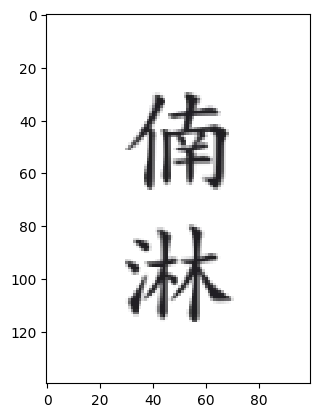

In [8]:
def remove_background(img, crop=True):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
  
  img_grey = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
  
  y, x = np.where(img_grey > 250)
  
  img_cp = img.copy()
  
  img_cp[y, x] = np.full(4, 0, dtype=np.uint8)
  
  return img_cp

def get_blank(width, height, bg='white'):
  blank = np.zeros((height, width, 4), dtype=np.uint8)
  
  if bg == 'white':
    blank[:, :] = np.array([255, 255, 255, 255], dtype=np.uint8)
  elif bg == 'black':
    blank[:, :] = np.array([0, 0, 0, 255], dtype=np.uint8)
  
  return blank

def insert_img(src, insert, x, y):
  h, w = insert.shape[:2]

  # normalize alpha to 0 ~ 1
  src_alpha = src[y:y+h, x:x+w, 3] / 255.0
  ins_alpha = insert[:, :, 3] / 255.0

  # blend src and insert channel by channel
  for ch in range(0, 3):
    src[y:y+h, x:x+w, ch] = ins_alpha * insert[:, :, ch] + \
                            src_alpha * src[y:y+h, x:x+w, ch] * (1 - ins_alpha)

  # denoramlize alpha to 0 ~ 255
  src[y:y+h, x:x+w, 3] = (1 - (1 - ins_alpha) * (1 - src_alpha)) * 255
  
  return src

def resize_img_by_height(img, target_height):
  og_h, og_w = img.shape[:2]
  
  resize_ratio = target_height / og_h
  resize_width = round(og_w * resize_ratio)
  
  return cv2.resize(img, dsize=(resize_width, target_height), interpolation=None)

insert_paths = [note_paths['nam_d'], note_paths['lim_u']]
positions = [ (30, 30), (30, 80) ]

img = get_blank(100, 140)

target_height = 37

for idx, ins_path in enumerate(insert_paths):
  ins = cv2.imread(ins_path, cv2.IMREAD_UNCHANGED)
  
  ins_re = resize_img_by_height(ins, target_height)
  ins_re = remove_background(ins_re)
  
  ins_x, ins_y = positions[idx]
  
  img = insert_img(img, ins_re, ins_x, ins_y)

plt.imshow(img, interpolation='none')

(27, 27, 4)

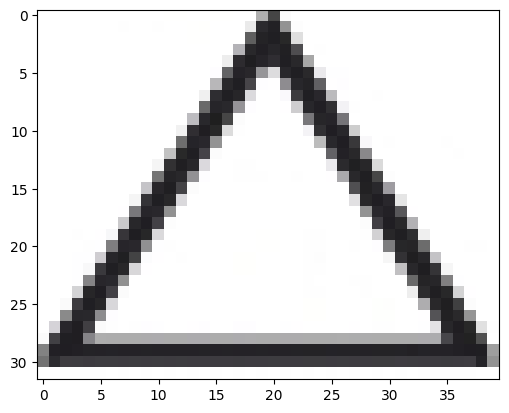

In [99]:
def make_mark(img, name):
  width = MARK_WIDTHS[name]
  img_rs = cv2.resize(img, dsize=( width, round(img.shape[0]/img.shape[1] * width) ))
  
  bg = get_blank(width, MARK_HEIGHT)
  
  return insert_img(bg, img_rs, 0, MARK_HEIGHT//2 - img_rs.shape[0]//2)

mark_name = 'pause'
mark_img = cv2.imread(note_paths[mark_name], cv2.IMREAD_UNCHANGED)

plt.imshow(mark_img)

make_mark(mark_img, mark_name).shape

청임:5


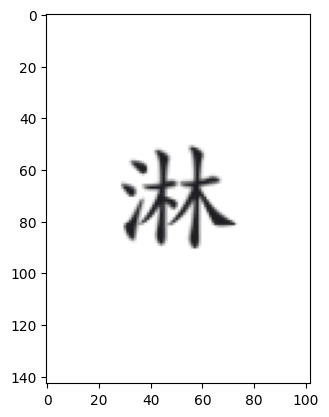

In [144]:
img_w, img_h = get_size()
img = get_blank(img_w, img_h)

pitch_range = get_pitch_range()
jng_dict = get_jng_dict( pitch_range, div=( 2 if img_h/img_w < 1.0 else None ) )

# label format
jng_dict_format = {
  'row_div': jng_dict['row_div'],
  'rows': [ { 'col_div': row['col_div'], 'cols': [ (0, 0, 0, 0, col) for col in row['cols'] ]} for row in jng_dict['rows'] ]
}

print(JeongganProcessor.get_label( jng_dict_format ))

# image generation
row_div = jng_dict['row_div']

note_height = 40 if row_div == 1 else 36

row_heights = []
for row in jng_dict['rows']:
  if row['col_div'] == 1 and row['cols'][0] == 'conti':
    row_heights.append(mark_height)
    continue
  
  row_heights.append(note_height)

gap = (img_h - sum(row_heights)) // (row_div + 1)

row_template = [ gap + idx * (row_heights[idx - 1 if idx > 0 else idx] + gap) for idx in range(row_div) ]

for row_idx, row in enumerate(jng_dict['rows']):
  col_div = row['col_div']
  
  notes = [] 
  for note_name in row['cols']:
    note_img_path = note_paths[note_name]
    
    if isinstance(note_img_path, list):
      note_img_path = choice(note_img_path)
    
    note_img = cv2.imread(note_img_path, cv2.IMREAD_UNCHANGED)
    
    if note_name in ('conti', 'pause'):
      note_img = make_mark(note_img, note_name)
    else:
      note_img = resize_img_by_height(note_img, note_height)
    
    note_img = remove_background(note_img)
    
    notes.append((note_img, note_name))
  
  gap = ( img_w - sum( [ note[0].shape[1] for note in notes ] ) ) // (col_div + 1)
  col_template = [ gap + idx * (notes[idx - 1 if idx > 0 else idx][0].shape[1] + gap) for idx in range(col_div) ] if col_div > 1 else [ round(img_w / 2) - round(notes[0][0].shape[1] / 2) ]
  
  for col_idx, note_tuple in enumerate(notes):
    note, note_name = note_tuple
    
    pos_x = col_template[col_idx]
    pos_y = row_template[row_idx]
    
    if note_name == 'conti':
      pos_y += (note_height - note.shape[0]) // 2
  
    img = insert_img(img, note, pos_x, pos_y)

plt.imshow(img, interpolation=None)